# Install Requirement

In [1]:
!pip install roboflow
!pip install ultralytics
!pip install huggingface-hub
!pip install albumentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.8 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 904.3/904.3 kB 21.7 MB/s eta 0:00:00


In [2]:
!nvidia-smi

Tue Dec 31 01:59:50 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Import required packages

In [3]:
import albumentations as A
import cv2
import os
import glob
import matplotlib.pyplot as plt
from pathlib import Path
from IPython import display
import ultralytics
from google.colab import drive

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# YOLOv11 Ultralytics

In [4]:
display.clear_output()
ultralytics.checks()

Ultralytics 8.3.55 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.7/112.6 GB disk)


# Prepare data

In [6]:
drive.mount('/content/drive')

Mounted at /content/drive


## Data augmentation

In [7]:
transform = A.Compose(
    [
        A.Rotate(limit=30, p=0.8),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.3),
        A.RandomBrightnessContrast(p=0.7),
        A.Blur(blur_limit=3, p=0.3),
        A.CLAHE(p=0.3),
        A.Resize(640, 640, always_apply=True)
    ],
    bbox_params=A.BboxParams(format="yolo", label_fields=["category_ids"])
)

In [8]:
def augment_images(images_dir, labels_dir, save_dir, aug_count=1):
    images_path = sorted(glob.glob(os.path.join(images_dir, "*.jpg")))
    labels_path = sorted(glob.glob(os.path.join(labels_dir, "*.txt")))

    Path(save_dir / "images").mkdir(parents=True, exist_ok=True)
    Path(save_dir / "labels").mkdir(parents=True, exist_ok=True)

    for img_path, lbl_path in zip(images_path, labels_path):
        image = cv2.imread(img_path)
        height, width, _ = image.shape

        with open(lbl_path, "r") as f:
            boxes = []
            category_ids = []
            for line in f:
                class_id, x, y, w, h = map(float, line.strip().split())
                boxes.append([x, y, w, h])
                category_ids.append(int(class_id))

        for i in range(aug_count):
            augmented = transform(image=image, bboxes=boxes, category_ids=category_ids)
            aug_image = augmented["image"]
            aug_boxes = augmented["bboxes"]
            aug_category_ids = augmented["category_ids"]

            aug_img_filename = f"{Path(img_path).stem}_aug_{i}.jpg"
            aug_img_path = os.path.join(save_dir, "images", aug_img_filename)
            cv2.imwrite(aug_img_path, aug_image)

            aug_lbl_filename = f"{Path(lbl_path).stem}_aug_{i}.txt"
            aug_lbl_path = os.path.join(save_dir, "labels", aug_lbl_filename)
            with open(aug_lbl_path, "w") as f:
                for cat_id, bbox in zip(aug_category_ids, aug_boxes):
                    f.write(f"{cat_id} {bbox[0]} {bbox[1]} {bbox[2]} {bbox[3]}\n")

In [9]:
train_images_dir = "/content/drive/MyDrive/AThanh/dataset/train/images"
train_labels_dir = "/content/drive/MyDrive/AThanh/dataset/train/labels"
augmented_save_dir = Path("/content/drive/MyDrive/AThanh/dataset/augmented/train")

In [10]:
augment_images(train_images_dir, train_labels_dir, augmented_save_dir, aug_count=2)

## Count the augmented data

In [11]:
def count_data(images_dir, labels_dir, augmented_dir):
    num_original_images = len(glob.glob(os.path.join(images_dir, "*.jpg")))
    num_original_labels = len(glob.glob(os.path.join(labels_dir, "*.txt")))

    aug_images_dir = os.path.join(augmented_dir, "images")
    aug_labels_dir = os.path.join(augmented_dir, "labels")
    num_augmented_images = len(glob.glob(os.path.join(aug_images_dir, "*.jpg")))
    num_augmented_labels = len(glob.glob(os.path.join(aug_labels_dir, "*.txt")))

    total_images = num_original_images + num_augmented_images
    total_labels = num_original_labels + num_augmented_labels

    print(f"Number of original images: {num_original_images}")
    print(f"Number of original labels: {num_original_labels}")
    print(f"Number of augmented images: {num_augmented_images}")
    print(f"Number of augmented labels: {num_augmented_labels}")
    print(f"Total images (original + augmented): {total_images}")
    print(f"Total labels (original + augmented): {total_labels}")

In [12]:
train_images_dir = "/content/drive/MyDrive/AThanh/dataset/train/images"
train_labels_dir = "/content/drive/MyDrive/AThanh/dataset/train/labels"
augmented_save_dir = "/content/drive/MyDrive/AThanh/dataset/augmented/train"

In [13]:
count_data(train_images_dir, train_labels_dir, augmented_save_dir)

Number of original images: 997
Number of original labels: 997
Number of augmented images: 1994
Number of augmented labels: 1994
Total images (original + augmented): 2991
Total labels (original + augmented): 2991


In [14]:
def plot_image_with_boxes(image_path, label_path, title):
    image = cv2.imread(image_path)
    height, width, _ = image.shape

    with open(label_path, "r") as f:
        for line in f:
            class_id, x, y, w, h = map(float, line.strip().split())
            x1 = int((x - w / 2) * width)
            y1 = int((y - h / 2) * height)
            x2 = int((x + w / 2) * width)
            y2 = int((y + h / 2) * height)
            color = (0, 255, 0)
            cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
            cv2.putText(image, f"Class {int(class_id)}", (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")

In [15]:
def display_original_with_augmented_pairs(original_images_dir, original_labels_dir, augmented_images_dir, augmented_labels_dir, num_examples=5):
    original_images = sorted(list(Path(original_images_dir).glob("*.jpg")))[:num_examples]

    fig, axes = plt.subplots(num_examples, 3, figsize=(15, 5 * num_examples))

    for i, orig_img_path in enumerate(original_images):
        orig_lbl_path = Path(original_labels_dir) / f"{orig_img_path.stem}.txt"

        plt.subplot(num_examples, 3, 3 * i + 1)
        plot_image_with_boxes(str(orig_img_path), str(orig_lbl_path), title="Original")

        aug_images = sorted(Path(augmented_images_dir).glob(f"{orig_img_path.stem}_aug_*.jpg"))
        for j, aug_img_path in enumerate(aug_images[:2]):
            aug_lbl_path = Path(augmented_labels_dir) / f"{aug_img_path.stem}.txt"
            plt.subplot(num_examples, 3, 3 * i + 2 + j)
            plot_image_with_boxes(str(aug_img_path), str(aug_lbl_path), title=f"Augmented {j + 1}")

    plt.tight_layout()
    plt.show()

In [16]:
train_images_dir = "/content/drive/MyDrive/AThanh/dataset/train/images"
train_labels_dir = "/content/drive/MyDrive/AThanh/dataset/train/labels"
aug_images_dir = "/content/drive/MyDrive/AThanh/dataset/augmented/train/images"
aug_labels_dir = "/content/drive/MyDrive/AThanh/dataset/augmented/train/labels"

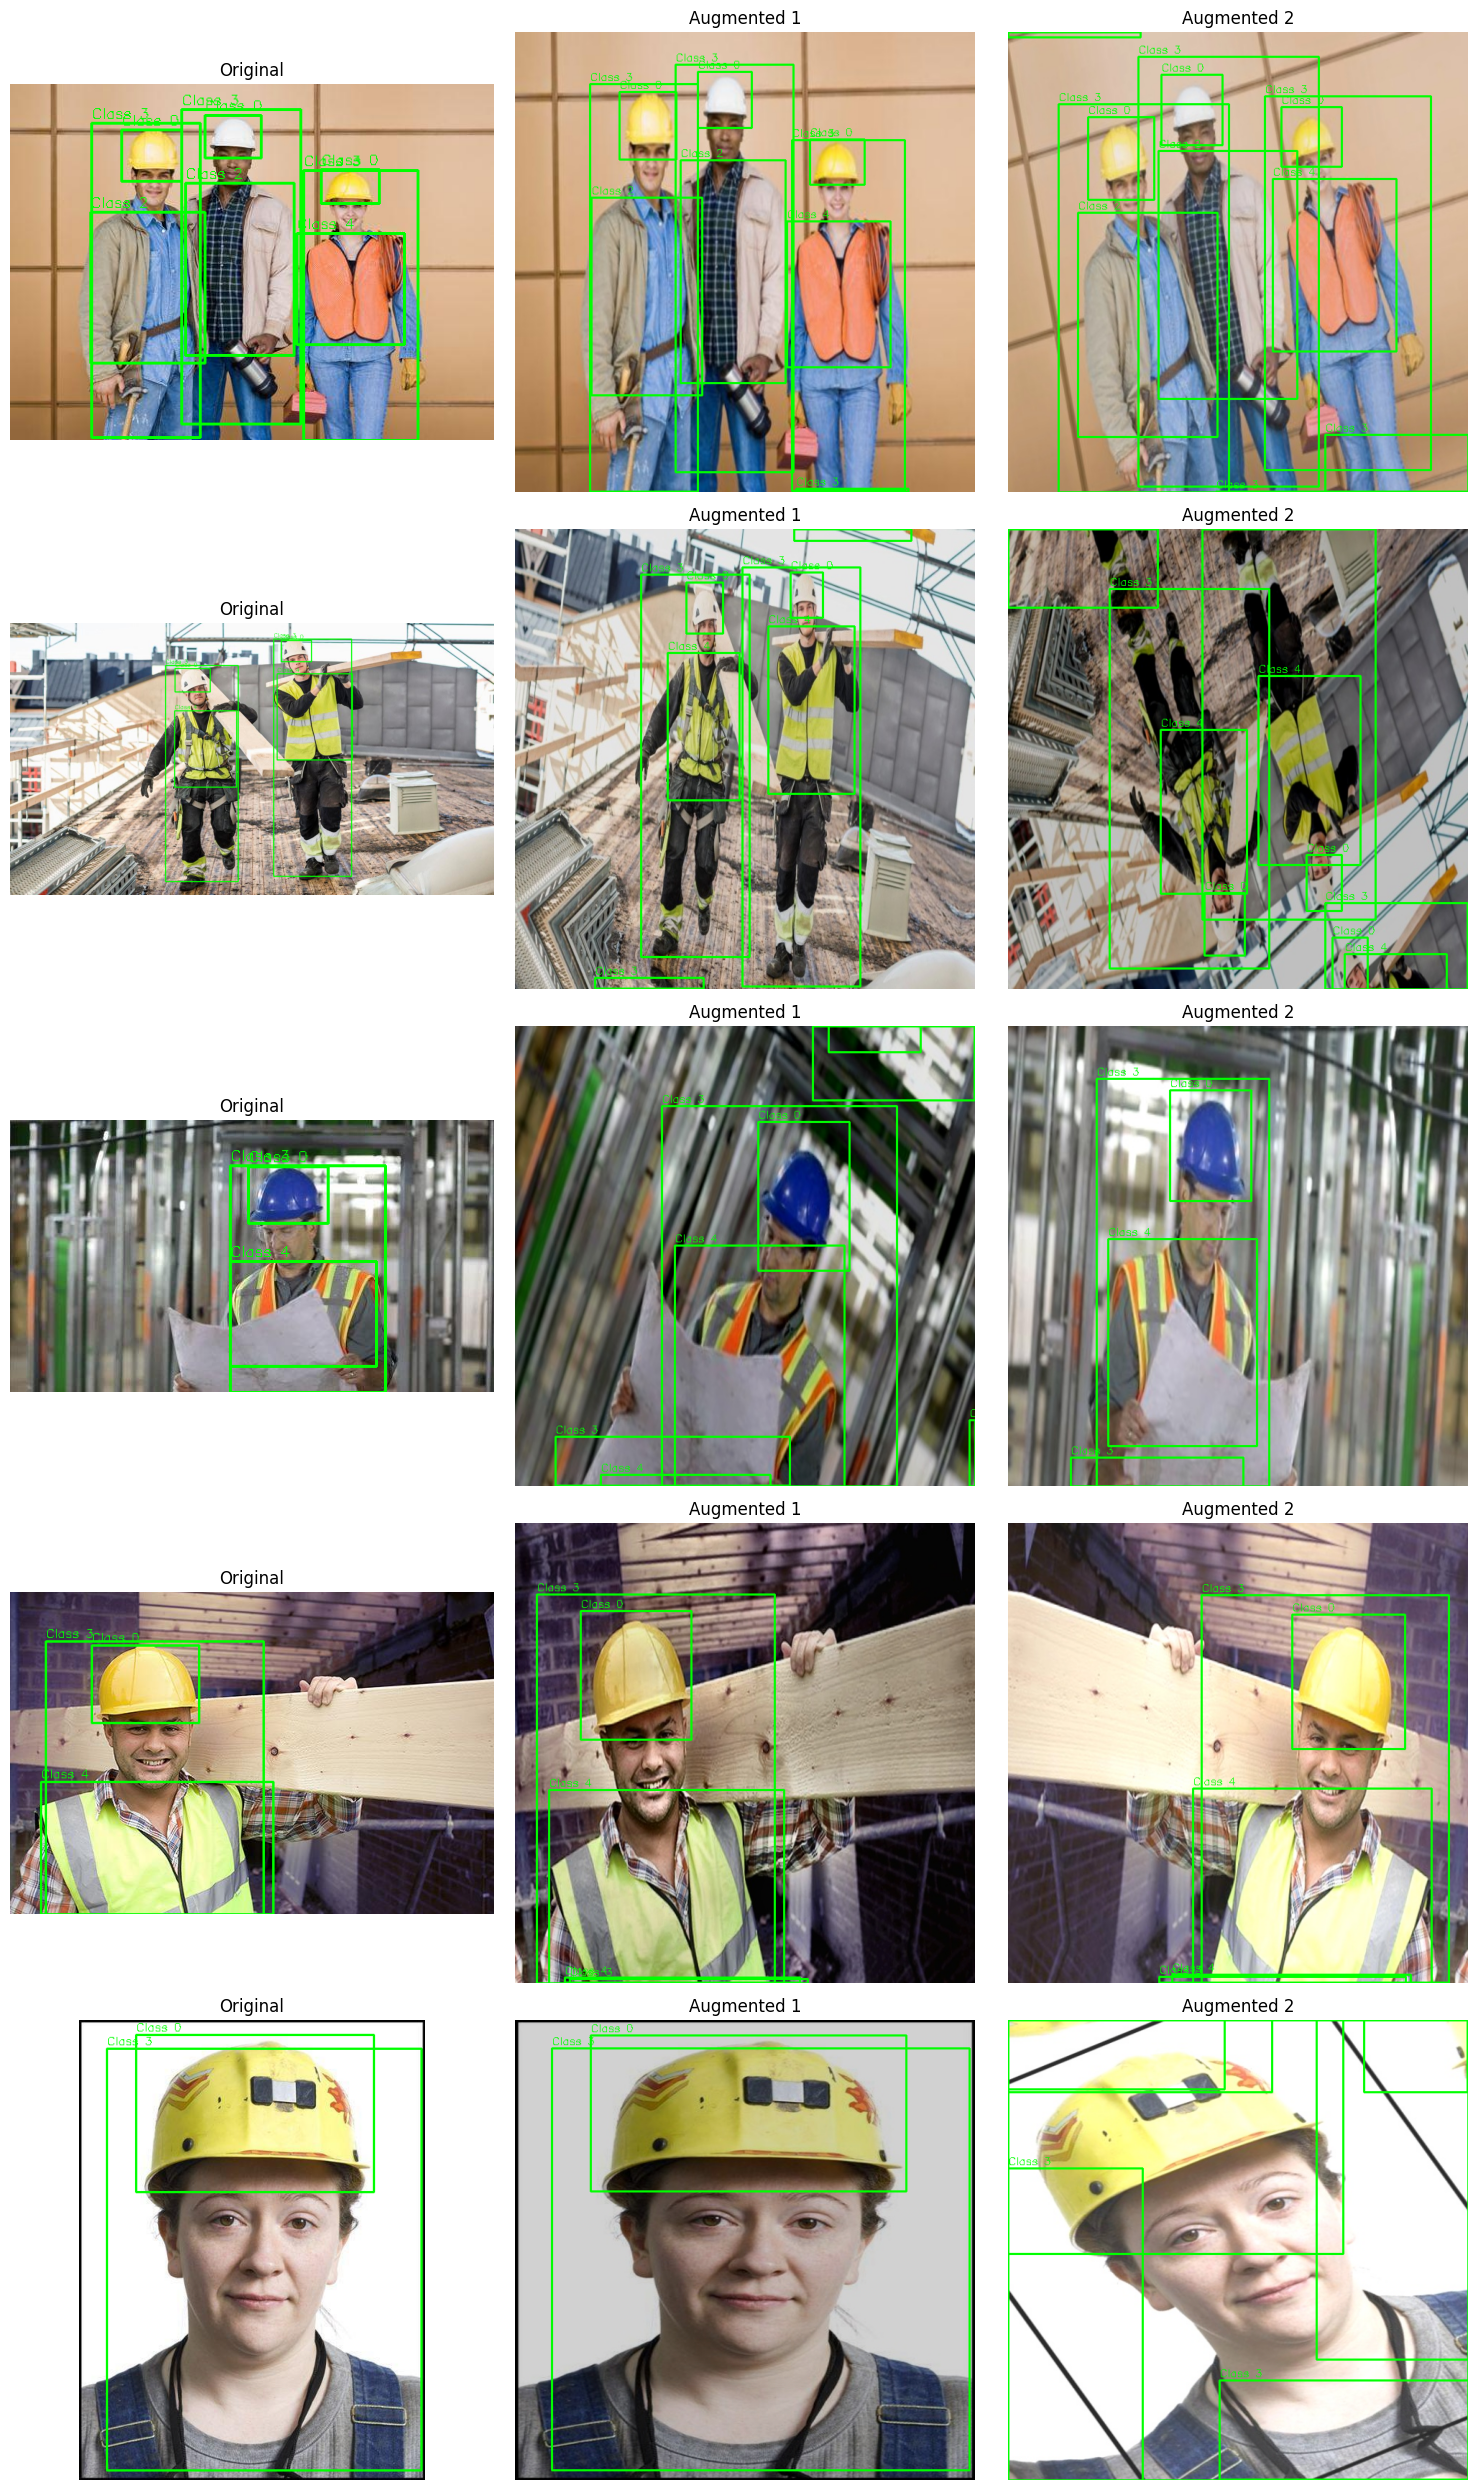

In [17]:
display_original_with_augmented_pairs(train_images_dir, train_labels_dir, aug_images_dir, aug_labels_dir, num_examples=5)

## Generate YAML configuration file

In [18]:
CLASS_NAMES = ['helmet', 'no-helmet', 'no-vest', 'person', 'vest']

In [20]:
import yaml
from pathlib import Path

def create_yaml_file(dataset_path, train_images, val_images, test_images=None, class_names=CLASS_NAMES):
    data = {
        'path': str(dataset_path),
        'train': str(Path(train_images).relative_to(dataset_path)),
        'val': str(Path(val_images).relative_to(dataset_path)),
    }

    if test_images:
        data['test'] = str(Path(test_images).relative_to(dataset_path))

    data['nc'] = len(class_names)
    data['names'] = class_names

    yaml_path = Path(dataset_path) / 'dataset.yaml'
    with open(yaml_path, 'w') as file:
        yaml.dump(data, file, default_flow_style=False)

    print(f"YAML file created at {yaml_path}")

In [21]:
dataset_root = Path("/content/drive/MyDrive/AThanh/dataset")
train_images_dir = dataset_root / "augmented/train/images"
val_images_dir = dataset_root / "valid/images"
test_images_dir = dataset_root / "test/images"

In [22]:
create_yaml_file(dataset_root, train_images_dir, val_images_dir, test_images_dir, class_names=CLASS_NAMES)

YAML file created at /content/drive/MyDrive/AThanh/dataset/dataset.yaml


# Train YOLOv11 model

In [23]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import pandas as pd

In [24]:
model = YOLO("yolo11n.pt")

results = model.train(
    data="/content/drive/MyDrive/AThanh/dataset/dataset.yaml",
    epochs=100,
    batch=16,
    lr0=1e-4,
    imgsz=640,
)

metrics = model.val()

print(metrics)

100%|██████████| 5.35M/5.35M [00:00<00:00, 160MB/s]

Ultralytics 8.3.55 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/drive/MyDrive/AThanh/dataset/dataset.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, s

100%|██████████| 755k/755k [00:00<00:00, 44.3MB/s]


Overriding model.yaml nc=80 with nc=5

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/drive/MyDrive/AThanh/dataset/augmented/train/labels... 1994 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1994/1994 [00:37<00:00, 53.18it/s] 


train: New cache created: /content/drive/MyDrive/AThanh/dataset/augmented/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/AThanh/dataset/valid/labels.cache... 119 images, 0 backgrounds, 0 corrupt: 100%|██████████| 119/119 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100       3.1G       1.79      2.826      1.817        101        640: 100%|██████████| 125/125 [00:59<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.33s/it]

                   all        119        715      0.653      0.479      0.488      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.78G      1.705      1.915      1.747        135        640: 100%|██████████| 125/125 [00:55<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.68it/s]

                   all        119        715      0.728      0.485      0.528      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.78G      1.681      1.842      1.735        181        640: 100%|██████████| 125/125 [00:55<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.07it/s]

                   all        119        715      0.672      0.491      0.509       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.98G      1.675       1.81      1.737        137        640: 100%|██████████| 125/125 [00:54<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]

                   all        119        715      0.782      0.541      0.594      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100         3G      1.639      1.748      1.719        123        640: 100%|██████████| 125/125 [00:53<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]

                   all        119        715      0.758      0.549      0.582      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.98G      1.618      1.699      1.697        136        640: 100%|██████████| 125/125 [00:53<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.38it/s]

                   all        119        715      0.808       0.53      0.639      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100       2.7G      1.615      1.659      1.684        193        640: 100%|██████████| 125/125 [00:53<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.18it/s]

                   all        119        715      0.787      0.601      0.657       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      3.03G      1.583      1.608      1.656        168        640: 100%|██████████| 125/125 [00:54<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.43it/s]

                   all        119        715      0.791       0.58      0.651      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      3.12G      1.558      1.559      1.642        145        640: 100%|██████████| 125/125 [00:55<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.18it/s]

                   all        119        715      0.619      0.608      0.679      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.91G      1.554      1.541      1.638        139        640: 100%|██████████| 125/125 [00:55<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.23it/s]

                   all        119        715      0.813      0.619      0.695      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.68G      1.536      1.515      1.631        177        640: 100%|██████████| 125/125 [00:55<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.26it/s]

                   all        119        715      0.808      0.625      0.718      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.74G      1.527      1.493      1.618        176        640: 100%|██████████| 125/125 [00:53<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]

                   all        119        715      0.636      0.615      0.707      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100       3.2G      1.502      1.469      1.603        115        640: 100%|██████████| 125/125 [00:53<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.24it/s]

                   all        119        715       0.88       0.64      0.787      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.92G      1.514      1.439        1.6         91        640: 100%|██████████| 125/125 [00:54<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.97it/s]

                   all        119        715      0.861      0.632      0.759       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.65G      1.497      1.435      1.594        198        640: 100%|██████████| 125/125 [00:54<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]

                   all        119        715       0.85      0.641      0.787      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.83G      1.492      1.423      1.593        130        640: 100%|██████████| 125/125 [00:54<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.05it/s]

                   all        119        715      0.732      0.757      0.804      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.87G      1.474       1.38      1.569        110        640: 100%|██████████| 125/125 [00:54<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.27it/s]

                   all        119        715      0.733      0.752      0.779       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.64G      1.483      1.383      1.577        148        640: 100%|██████████| 125/125 [00:54<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]

                   all        119        715      0.861      0.642      0.767       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.95G      1.476      1.359      1.564        177        640: 100%|██████████| 125/125 [00:53<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]

                   all        119        715      0.768      0.691      0.777      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.82G      1.473       1.35      1.568        195        640: 100%|██████████| 125/125 [00:54<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.37it/s]

                   all        119        715      0.802       0.67      0.781      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.89G      1.455      1.346      1.559        118        640: 100%|██████████| 125/125 [00:54<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.21it/s]

                   all        119        715      0.851      0.666      0.839      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.76G      1.456       1.36      1.568        125        640: 100%|██████████| 125/125 [00:55<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.22it/s]

                   all        119        715      0.728      0.762      0.823      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.97G      1.424      1.313      1.542        126        640: 100%|██████████| 125/125 [00:55<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.17it/s]

                   all        119        715      0.609      0.743      0.767      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.97G       1.43        1.3      1.542        151        640: 100%|██████████| 125/125 [00:54<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.32it/s]

                   all        119        715      0.839      0.688      0.808      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      3.32G      1.432      1.292      1.535        121        640: 100%|██████████| 125/125 [00:54<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]

                   all        119        715      0.798      0.753      0.819      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      3.05G      1.414      1.284      1.527        143        640: 100%|██████████| 125/125 [00:54<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]

                   all        119        715      0.798        0.7      0.801      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      3.17G      1.412      1.268      1.531        125        640: 100%|██████████| 125/125 [00:55<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.53it/s]

                   all        119        715      0.807      0.752      0.826      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.79G       1.41      1.244      1.524        130        640: 100%|██████████| 125/125 [00:55<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]

                   all        119        715      0.756      0.789      0.828      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      3.09G        1.4      1.222      1.506        123        640: 100%|██████████| 125/125 [00:55<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.37it/s]

                   all        119        715      0.766       0.81      0.832      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.97G      1.398      1.258      1.523        125        640: 100%|██████████| 125/125 [00:54<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.28it/s]

                   all        119        715      0.869       0.68      0.807      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      3.08G      1.392      1.227      1.511         99        640: 100%|██████████| 125/125 [00:54<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.28it/s]

                   all        119        715      0.759      0.773      0.848      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      3.12G      1.391      1.213      1.499        127        640: 100%|██████████| 125/125 [00:54<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.27it/s]

                   all        119        715      0.761      0.723        0.8       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.78G      1.375      1.198      1.491        151        640: 100%|██████████| 125/125 [00:55<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]

                   all        119        715      0.771      0.779      0.821       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.99G      1.364       1.18      1.492        206        640: 100%|██████████| 125/125 [00:54<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.44it/s]

                   all        119        715      0.878       0.69      0.803      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100       3.1G       1.37      1.192      1.492        158        640: 100%|██████████| 125/125 [00:53<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.39it/s]

                   all        119        715      0.852      0.724      0.803      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100         3G      1.372      1.182      1.484        130        640: 100%|██████████| 125/125 [00:55<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.75it/s]

                   all        119        715      0.817       0.75       0.83      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.92G      1.352      1.172      1.483        220        640: 100%|██████████| 125/125 [00:54<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]

                   all        119        715      0.768       0.79      0.837       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.76G      1.338      1.144      1.467        107        640: 100%|██████████| 125/125 [00:55<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.26it/s]

                   all        119        715      0.855      0.714      0.779       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.77G      1.344       1.16      1.477        124        640: 100%|██████████| 125/125 [00:54<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]

                   all        119        715      0.776      0.814      0.856      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.82G      1.339      1.154      1.478        123        640: 100%|██████████| 125/125 [00:54<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.30it/s]

                   all        119        715      0.775      0.802      0.865      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.92G       1.34      1.153      1.473        193        640: 100%|██████████| 125/125 [00:53<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.12it/s]

                   all        119        715      0.822      0.768      0.802      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      3.07G       1.33      1.139      1.461        127        640: 100%|██████████| 125/125 [00:53<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.42it/s]

                   all        119        715      0.844      0.674      0.803      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.87G      1.334      1.114      1.456        112        640: 100%|██████████| 125/125 [00:54<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.63it/s]

                   all        119        715      0.873      0.733      0.823      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      3.24G      1.314      1.105      1.456        157        640: 100%|██████████| 125/125 [00:54<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]

                   all        119        715      0.823      0.788      0.804      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.94G       1.33      1.123      1.462        102        640: 100%|██████████| 125/125 [00:55<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

                   all        119        715      0.731      0.803      0.841       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.71G      1.311      1.092      1.449        117        640: 100%|██████████| 125/125 [00:55<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  2.00it/s]

                   all        119        715      0.778      0.813      0.853       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.97G       1.31      1.094       1.45        128        640: 100%|██████████| 125/125 [00:53<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.35it/s]

                   all        119        715      0.859      0.719      0.833       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.77G      1.298      1.087      1.437        140        640: 100%|██████████| 125/125 [00:54<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.15it/s]

                   all        119        715       0.77      0.773      0.832      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.84G        1.3       1.09       1.44        139        640: 100%|██████████| 125/125 [00:54<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]

                   all        119        715      0.833      0.826      0.871      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.69G      1.296      1.078      1.433        161        640: 100%|██████████| 125/125 [00:53<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.23it/s]

                   all        119        715      0.811      0.845      0.887      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.79G      1.281      1.064      1.429        129        640: 100%|██████████| 125/125 [00:53<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.59it/s]

                   all        119        715      0.741      0.796      0.808      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.86G      1.287      1.061      1.428        132        640: 100%|██████████| 125/125 [00:53<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.16it/s]

                   all        119        715      0.797       0.84      0.901      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100       3.3G      1.279      1.055      1.415        179        640: 100%|██████████| 125/125 [00:53<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.55it/s]

                   all        119        715      0.777      0.812      0.845       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.88G      1.275      1.039      1.417        125        640: 100%|██████████| 125/125 [00:53<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.45it/s]

                   all        119        715      0.751      0.778      0.815      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.85G      1.268       1.04      1.419        155        640: 100%|██████████| 125/125 [00:53<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.39it/s]

                   all        119        715      0.809      0.672      0.801      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100       2.7G      1.266      1.044      1.418        136        640: 100%|██████████| 125/125 [00:53<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.23it/s]

                   all        119        715      0.776      0.843      0.854      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.75G      1.267      1.045      1.419         74        640: 100%|██████████| 125/125 [00:53<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.36it/s]

                   all        119        715      0.814      0.784      0.816      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.75G      1.267      1.044      1.418        143        640: 100%|██████████| 125/125 [00:52<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.65it/s]

                   all        119        715      0.766      0.836      0.872      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.97G      1.254      1.018      1.409        157        640: 100%|██████████| 125/125 [00:52<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.36it/s]

                   all        119        715      0.734      0.822      0.829      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.71G      1.249      1.017      1.401        107        640: 100%|██████████| 125/125 [00:52<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.71it/s]

                   all        119        715      0.852      0.799      0.869      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.69G      1.243      1.007      1.398        201        640: 100%|██████████| 125/125 [00:52<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.29it/s]

                   all        119        715      0.799      0.769      0.838      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.82G      1.232     0.9985      1.391         82        640: 100%|██████████| 125/125 [00:53<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.40it/s]

                   all        119        715       0.84      0.761      0.828      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.78G      1.235     0.9956      1.392        165        640: 100%|██████████| 125/125 [00:53<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.67it/s]

                   all        119        715      0.802      0.747      0.813      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      3.04G      1.229      1.003       1.39        174        640: 100%|██████████| 125/125 [00:54<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.51it/s]

                   all        119        715      0.843      0.716      0.815      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      3.06G      1.222     0.9958      1.386        143        640: 100%|██████████| 125/125 [00:54<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.24it/s]

                   all        119        715      0.792      0.778      0.831       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.84G      1.229     0.9911      1.389        148        640: 100%|██████████| 125/125 [00:54<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]

                   all        119        715      0.755      0.809      0.829      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      3.23G      1.214     0.9718      1.373        129        640: 100%|██████████| 125/125 [00:54<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.39it/s]

                   all        119        715      0.838      0.708      0.814      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.66G      1.215     0.9779      1.376         99        640: 100%|██████████| 125/125 [00:54<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.43it/s]

                   all        119        715      0.827      0.808      0.875      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.71G       1.22     0.9753      1.379        121        640: 100%|██████████| 125/125 [00:54<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.51it/s]

                   all        119        715      0.773      0.802       0.83      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.91G      1.198     0.9675      1.369        132        640: 100%|██████████| 125/125 [00:52<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]

                   all        119        715      0.737      0.816      0.828      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.81G      1.211     0.9654       1.38        103        640: 100%|██████████| 125/125 [00:52<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.41it/s]

                   all        119        715      0.836      0.821      0.846      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      3.02G      1.201     0.9598      1.369        171        640: 100%|██████████| 125/125 [00:54<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]

                   all        119        715      0.839      0.842      0.878      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.76G      1.186     0.9395      1.358        130        640: 100%|██████████| 125/125 [00:53<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.27it/s]

                   all        119        715      0.833       0.78      0.862      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      3.27G      1.188     0.9416      1.359        177        640: 100%|██████████| 125/125 [00:53<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.46it/s]

                   all        119        715      0.792      0.831      0.861      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      3.13G      1.189     0.9462      1.366        123        640: 100%|██████████| 125/125 [00:54<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]

                   all        119        715      0.882      0.764      0.861      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      3.09G      1.182     0.9295      1.352        112        640: 100%|██████████| 125/125 [00:54<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.22it/s]

                   all        119        715      0.837      0.791      0.867      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100       2.9G      1.177     0.9224      1.351         88        640: 100%|██████████| 125/125 [00:53<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.23it/s]

                   all        119        715      0.842      0.772      0.852      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      3.02G      1.176     0.9346      1.355        110        640: 100%|██████████| 125/125 [00:53<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.64it/s]

                   all        119        715      0.848      0.754      0.821      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.89G      1.166     0.9213      1.346        133        640: 100%|██████████| 125/125 [00:53<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.66it/s]

                   all        119        715      0.843      0.785      0.846      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.95G      1.159     0.9173      1.341        140        640: 100%|██████████| 125/125 [00:52<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.21it/s]

                   all        119        715      0.872      0.776      0.855      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      3.01G      1.164      0.921      1.352         98        640: 100%|██████████| 125/125 [00:52<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]

                   all        119        715      0.855      0.761      0.833      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.96G       1.16     0.9027      1.333        157        640: 100%|██████████| 125/125 [00:53<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.19it/s]

                   all        119        715      0.859      0.763      0.835      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.86G      1.148     0.9097      1.336         71        640: 100%|██████████| 125/125 [00:53<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.59it/s]

                   all        119        715      0.884      0.761      0.842      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100       3.2G      1.146     0.8974      1.333        111        640: 100%|██████████| 125/125 [00:52<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]

                   all        119        715      0.852      0.776      0.838      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.89G       1.14     0.8921      1.331        108        640: 100%|██████████| 125/125 [00:53<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.55it/s]

                   all        119        715      0.804      0.778      0.826      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.73G       1.14     0.8915      1.325        109        640: 100%|██████████| 125/125 [00:53<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]

                   all        119        715      0.835      0.776      0.848      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.91G       1.14     0.8991      1.324        193        640: 100%|██████████| 125/125 [00:53<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

                   all        119        715      0.817      0.788      0.849      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      3.05G      1.132     0.8894      1.322        128        640: 100%|██████████| 125/125 [00:54<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.68it/s]

                   all        119        715      0.843      0.783      0.848       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      3.18G      1.136     0.8877      1.324        203        640: 100%|██████████| 125/125 [00:52<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]

                   all        119        715      0.823        0.8      0.856      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100         3G      1.125     0.8792      1.314        167        640: 100%|██████████| 125/125 [00:52<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.45it/s]

                   all        119        715      0.819      0.769      0.841       0.44


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.53G      1.077      0.742      1.314         84        640: 100%|██████████| 125/125 [00:53<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.25it/s]

                   all        119        715      0.854      0.758      0.861      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.61G      1.061     0.7152      1.304         75        640: 100%|██████████| 125/125 [00:51<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.40it/s]

                   all        119        715      0.807      0.765      0.839      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.55G      1.046     0.7036      1.295         85        640: 100%|██████████| 125/125 [00:51<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.45it/s]

                   all        119        715      0.818      0.758      0.846      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.56G      1.035     0.6866      1.283        114        640: 100%|██████████| 125/125 [00:51<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.41it/s]

                   all        119        715      0.818      0.756       0.85      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.65G      1.038     0.6911      1.292        122        640: 100%|██████████| 125/125 [00:49<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]

                   all        119        715      0.813      0.775      0.852      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.65G      1.027     0.6828      1.278         75        640: 100%|██████████| 125/125 [00:50<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.40it/s]

                   all        119        715      0.824      0.777      0.853      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.53G       1.02     0.6796      1.278         62        640: 100%|██████████| 125/125 [00:49<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.35it/s]

                   all        119        715       0.83      0.775      0.856      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.59G       1.01     0.6691      1.265         73        640: 100%|██████████| 125/125 [00:49<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.64it/s]

                   all        119        715       0.82      0.799      0.855      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.54G       1.01     0.6694      1.271         51        640: 100%|██████████| 125/125 [00:50<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]

                   all        119        715       0.81       0.79       0.85      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.64G      1.009      0.675      1.271         64        640: 100%|██████████| 125/125 [00:52<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.43it/s]

                   all        119        715      0.806      0.791      0.849      0.446



100 epochs completed in 1.606 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.55 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,583,127 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.21s/it]


                   all        119        715      0.871      0.776      0.855      0.456
                helmet        117        232      0.855      0.909      0.935      0.518
             no-helmet          6         11      0.895      0.364      0.675      0.258
               no-vest         52         90      0.839      0.822      0.835      0.405
                person        115        241        0.9      0.929      0.927      0.629
                  vest         74        141      0.864      0.857      0.906      0.472
Speed: 0.5ms preprocess, 4.6ms inference, 0.0ms loss, 6.3ms postprocess per image
Results saved to runs/detect/train
Ultralytics 8.3.55 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,583,127 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /content/drive/MyDrive/AThanh/dataset/valid/labels.cache... 119 images, 0 backgrounds, 0 corrupt: 100%|██████████| 119/119 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.83it/s]


                   all        119        715        0.9      0.751      0.849      0.458
                helmet        117        232      0.865      0.905      0.929      0.517
             no-helmet          6         11          1      0.266      0.651       0.27
               no-vest         52         90      0.851      0.811      0.831        0.4
                person        115        241        0.9      0.921      0.925       0.63
                  vest         74        141      0.882      0.851      0.908      0.474
Speed: 0.4ms preprocess, 10.4ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs/detect/train2
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78a7fbf42320>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_resu

                             Metric     Value
0  Mean Average Precision (mAP@0.5)  0.848686
1                         Precision  0.899759
2                            Recall  0.750928


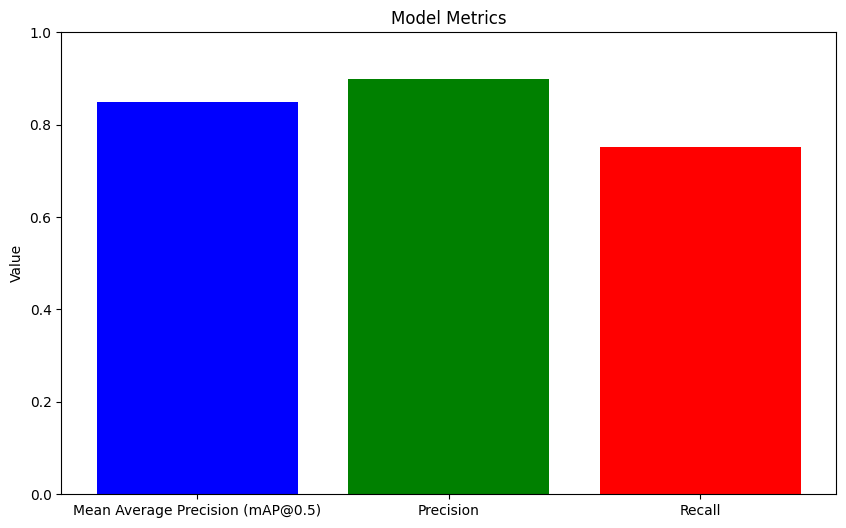

In [25]:
mAP50 = metrics.results_dict.get('metrics/mAP50(B)', 0)
precision = metrics.results_dict.get('metrics/precision(B)', 0)
recall = metrics.results_dict.get('metrics/recall(B)', 0)

metrics_df = pd.DataFrame({
    "Metric": ["Mean Average Precision (mAP@0.5)",
               "Precision", "Recall"],
    "Value": [mAP50, precision, recall]
})

print(metrics_df)

plt.figure(figsize=(10, 6))
plt.bar(metrics_df["Metric"], metrics_df["Value"], color=['blue', 'green', 'red'])
plt.title("Model Metrics")
plt.ylabel("Value")
plt.ylim(0, 1)
plt.show()

# Exporting model to Hugging Face

In [26]:
model = YOLO("runs/detect/train/weights/best.pt")

model.export(format="onnx")

Ultralytics 8.3.55 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.00GHz)
YOLO11n summary (fused): 238 layers, 2,583,127 parameters, 0 gradients, 6.3 GFLOPs

PyTorch: starting from 'runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 9, 8400) (5.2 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 232.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.6/142.6 kB 315.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.5/291.5 MB 281.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 236.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 186.3 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 22.0s, installed 3 packages: ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu']
requirements: ⚠️ Restart runtime or rerun command for upd

'runs/detect/train/weights/best.onnx'

## Deploy model on Hugging Face

In [27]:
from huggingface_hub import HfApi, HfFolder, Repository
import locale

In [28]:
# Define a function to override the default locale setting with UTF-8. This comes from search result [2]
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"

In [29]:
# Override locale settings
locale.getpreferredencoding = getpreferredencoding

In [30]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Token is valid (permission: fineGrained).
The token `luanle13` has been saved to /root/.cache/huggingface/stored_tokens
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate

In [31]:
from huggingface_hub import create_repo, upload_file

repo_id = "ltl1313ltl/construction-safety"

upload_file(
    path_or_fileobj="runs/detect/train/weights/best.pt",
    path_in_repo="model.pt",
    repo_id=repo_id,
    repo_type="model"
)

print(f"Model uploaded!")

best.pt:   0%|          | 0.00/5.48M [00:00<?, ?B/s]

Model uploaded!


In [32]:
trained_model = YOLO('/content/runs/detect/train/weights/best.pt')

test_image_path = '/content/pic3.png'

results = trained_model.predict(test_image_path, save=True, save_txt=True)

for result in results:
    img = result.plot()
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

FileNotFoundError: /content/pic3.png does not exist